In [224]:
import tensorflow as tf
import numpy as np
from scipy import misc
import os
import get_data
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [261]:
# Parameters of the data
image_size = 100  # Pixel width and height.
max_num_images = 30000
num_channels = 1
num_classes = 3
start_index = 0

# Metadata and labels
metadata = np.loadtxt('../data/gal_pos_label.txt', delimiter=',') # columns are: dr7objid,ra,dec,spiral,elliptical,uncertain 
gal_id = np.genfromtxt('../data/gal_pos_label.txt', delimiter=',', dtype=int, usecols=[0])   

In [260]:
# Download data if we don't already have it
get_data.maybe_download_indices(start_index, start_index + max_num_images)

KeyboardInterrupt: 

In [262]:
dataset = np.ndarray(
        shape=(max_num_images, image_size, image_size, num_channels), dtype=np.float32)
labels = np.ndarray(shape=(max_num_images, num_classes), dtype=np.int32)

In [263]:
k = 0
# Loop over galaxy ids, if we have the file then add the galaxy to our dataset
# The file may be missing or corrupt in which case we can skip
for i in range(gal_id.shape[0]):
    filename = '../images/img_{}.png'.format(gal_id[i])
    if os.path.isfile(filename):
        img = np.expand_dims(misc.imread(filename, flatten=1), axis=2)
        dataset[k] = img[50:150, 50:150, :]
        labels[k] = data[i, 3:6]
        k += 1
    if k == max_num_images:
        break

# We might not have filled up the data structure.  Trim if needed so we don't have zeros at the end
dataset = dataset[0:k]
labels = labels[0:k]

In [264]:
dataset.shape, labels.shape

((21642, 100, 100, 1), (21642, 3))

In [265]:
# Randomize the dataset
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation, :]
  return shuffled_dataset, shuffled_labels
randomized_dataset, randomized_labels = randomize(dataset, labels)

In [271]:
# Split into train, validation, test
n = dataset.shape[0]
train_cutoff = int(n * 0.8)
valid_cutoff = int(n * 0.9)

train_dataset = randomized_dataset[0:train_cutoff, :, :, :]
train_labels = randomized_labels[0:train_cutoff, :]
valid_dataset = randomized_dataset[train_cutoff:valid_cutoff, :, :, :]
valid_labels = randomized_labels[train_cutoff:valid_cutoff, :]
test_dataset = randomized_dataset[valid_cutoff:, :, :, :]
test_labels = randomized_labels[valid_cutoff:, :]

In [272]:
test_dataset.shape

(2165, 100, 100, 1)

array([1, 0, 0], dtype=int32)

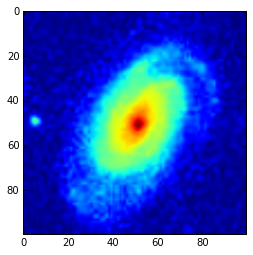

In [273]:
i=27

plt.imshow(train_dataset[i, :, :, 0])
train_labels[i]

In [ ]:
batch_size = 16
layer1_patch_size = 7
layer1_stride = 2
layer2_patch_size = 5
layer2_stride = 1
layer3_patch_size = 3
layer3_stride = 1

layer1_depth = 24
layer2_depth = 32
layer3_depth = 32
num_hidden = 800
MOVING_AVERAGE_DECAY = 0.999

graph = tf.Graph()

with graph.as_default():
  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [layer1_patch_size, layer1_patch_size, num_channels, layer1_depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([layer1_depth]))

  layer2_weights = tf.Variable(tf.truncated_normal(
      [layer2_patch_size, layer2_patch_size, layer1_depth, layer2_depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[layer2_depth]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      [layer3_patch_size, layer3_patch_size, layer2_depth, layer3_depth], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[layer3_depth]))

  layer4_weights = tf.Variable(tf.truncated_normal(
      [1568, num_hidden], stddev=0.1)) # TODO maths
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_classes], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_classes]))
    
  layer1_weight_decay = 0.0005
  layer2_weight_decay = 0.0005
  layer3_weight_decay = 0.0005
  layer4_weight_decay = 0.001
  layer5_weight_decay = 0.001

    # Track the moving averages of all trainable variables.
  variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
  variable_averages_op = variable_averages.apply(tf.trainable_variables())

  def getVar(v, averaged):
    if averaged:
      return variable_averages.average(v)
    else:
      return v
  
  # Model.
  def model(data, dropout=False, averaged=False):
    if dropout:
      keep_proba = 0.65
    else:
      keep_proba = 1
    
    w1 = getVar(layer1_weights, averaged)
    b1 = getVar(layer1_biases, averaged)
    w2 = getVar(layer2_weights, averaged)
    b2 = getVar(layer2_biases, averaged)
    w3 = getVar(layer3_weights, averaged)
    b3 = getVar(layer3_biases, averaged)
    w4 = getVar(layer4_weights, averaged)
    b4 = getVar(layer4_biases, averaged)
    w5 = getVar(layer5_weights, averaged)
    b5 = getVar(layer5_biases, averaged)
    
    conv = tf.nn.conv2d(data, w1, [1, layer1_stride, layer1_stride, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b1)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, w2, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b2)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, w3, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b3)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, w4) + b4)
    dropout = tf.nn.dropout(hidden, keep_proba)
    return tf.matmul(dropout, w5) + b5
  
  # Training computation.
  logits = model(tf_train_dataset, dropout=True)
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  l2_loss = (layer1_weight_decay * tf.nn.l2_loss(layer1_weights) 
             + layer2_weight_decay * tf.nn.l2_loss(layer2_weights)
             + layer3_weight_decay * tf.nn.l2_loss(layer3_weights)
             + layer4_weight_decay * tf.nn.l2_loss(layer4_weights)
             + layer5_weight_decay * tf.nn.l2_loss(layer5_weights))
    
  loss = cross_entropy + l2_loss
    
  # Optimizer.
  optimizer = tf.train.MomentumOptimizer(0.0001, 0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset, averaged=True))
  test_prediction = tf.nn.softmax(model(tf_test_dataset, averaged=True))

In [ ]:
num_steps = 50001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions, _ = session.run(
      [optimizer, loss, train_prediction, variable_averages_op], feed_dict=feed_dict)
    if (step % 100 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      valid_pred = valid_prediction.eval()
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_pred, valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)
  

Initialized
Minibatch loss at step 0 : 145.915
Minibatch accuracy: 31.2%
Validation accuracy: 36.0%

In [162]:
valid_labels

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ..., 
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=int32)

In [196]:
test_labels.sum(axis=0)

array([413, 181, 406])

In [199]:
train_labels.sum(axis=0) / float(train_labels.sum())

array([ 0.41566667,  0.18766667,  0.39666667])